As our data is sequential time series data we felt that it was important to reflect this in our approach to the test/traingin/valiadation split. 

2021-05-06
2022-08-05


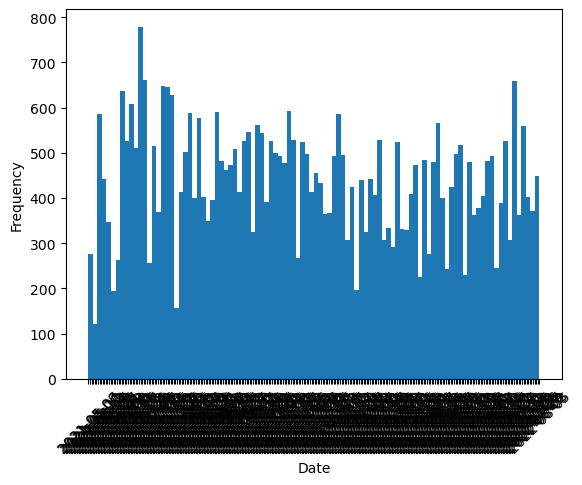

In [1]:
import pandas as pd
import numpy as np

#load the full dataset
df = pd.read_csv('data/Full_data.csv')

#print the range of the date column
print(df['date'].min())
print(df['date'].max())

#show the distribution of the date column in a plot with labels every 50 days
import matplotlib.pyplot as plt
plt.hist(df['date'], bins=100)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


plt.show()


We propose to take all points after 2022-05-01 to be our Test set, as this gives us one full year of coverage for our training, and conventiently represents around 20 percent of the data which is a commonly used split proportion.

In [2]:
#What percentage of the data is after 2022-05-01?	
print((df['date'] >= '2022-05-01').sum() / df['date'].count())

#use folium to show a map of the data points from after 2022-05-01
import folium
from folium.plugins import HeatMap

#filter the data
df_test = df[df['date'] >= '2022-05-01']

#initialize the map
m = folium.Map(location=[df_test['Lat'].mean(), df_test['Long'].mean()], zoom_start=2)

#add the data points
heat_data = [[row['Lat'], row['Long']] for index, row in df_test.iterrows()]

#plot the data points
HeatMap(heat_data).add_to(m)

#show the map in the notebook
m

0.19397307701068264


We can see from this map that the data in our test set is geographically well spread out across the region we cover. it should be noted however that any predictions on the basis of this test set will be an upper bound on accuracy in terms of using this algorithm to predict air pollution measures into the future or for the present day.

In [9]:
#export the test data to a csv file
df_test.to_csv('prepped_data/test_data.csv', index=False)

df_train = df[df['date'] < '2022-05-01']
df_train.to_csv('prepped_data/train_data.csv', index=False)

# Imputation and Standardisation

The next step is imputation of missings (by mean and KNN) and standardisation of the variables.

In [10]:
#set random seed
np.random.seed(42)

df_test = pd.read_csv('prepped_data/test_data.csv')
df_train = pd.read_csv('prepped_data/train_data.csv')

#Split train into X and Y
Xtrain = df_train.iloc[:, 7:].values
ytrain = df_train["PM25_ugm3"].values

#Split test into X and Y
Xtest = df_test.iloc[:, 7:].values
ytest = df_test["PM25_ugm3"].values

#running a simple imputer and scaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy = "mean")
Xtrain = imputer.fit_transform(Xtrain)
Xtest = imputer.transform(Xtest)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

# KNN imputation

In [11]:
#perform KNN imputation on the test data
from sklearn.impute import KNNImputer

#Split test and train into X and Y
Xtrain_KNN = df.iloc[:, 7:].values
ytrain = df["PM25_ugm3"].values

imputer = KNNImputer(n_neighbors=5)
Xtrain_KNN = imputer.fit_transform(Xtrain)
Xtest_KNN = imputer.transform(Xtest)

Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [12]:
#Export the data
np.savetxt('prepped_data/Xtrain.csv', Xtrain, delimiter=',')
np.savetxt('prepped_data/ytrain.csv', ytrain, delimiter=',')
np.savetxt('prepped_data/Xtest.csv', Xtest, delimiter=',')
np.savetxt('prepped_data/ytest.csv', ytest, delimiter=',')
np.savetxt('prepped_data/Xtrain_KNN.csv', Xtrain_KNN, delimiter=',')
np.savetxt('prepped_data/Xtest_KNN.csv', Xtest_KNN, delimiter=',')

The rest of the data will be used for both training and validation, with each classifier doing something similar to the below code as a method of cross-validation that is robust to the time discrepancy.

In [ ]:
import sklearn.model_selection
# sklearn.model_selection.TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0)